In [304]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

pd.set_option('notebook_repr_html', True)
pd.set_option('display.mpl_style', 'default') 

import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")
pd.set_option('precision', 10)
print('done!')


done!


In [2]:
shapes = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/shapes.txt.gz", compression='gzip')
agency = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/agency.txt.gz", compression='gzip')
trips = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/trips.txt.gz", compression='gzip')
routes = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/routes.txt.gz", compression='gzip')
stop_times = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/stop_times.txt.gz", compression='gzip')
calendar_dates = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/calendar_dates.txt.gz", compression='gzip')
stops = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/stops.txt.gz", index_col='stop_id', compression='gzip')
calendar = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/calendar.txt.gz", index_col='service_id', compression='gzip')

# Realtime traffic data
real_time_data = "https://s3-us-west-2.amazonaws.com/data-incubator/realtime.csv.gz"
realtime = pd.read_csv(real_time_data, compression='gzip', index_col=0, parse_dates=True)
print("{:,} rows x {} cols".format(realtime.shape[0], realtime.shape[1]))

2,846,294 rows x 12 cols


`Route Type: 
0: Tram, Streetcar, Light rail
1 : Subway, Metro. Any underground rail system
2 : Rail. Intercity or long-distance travel
3 : Bus, short- and long-distance
4 : Ferry, short- and long-distance 
5 : Cable Car, street-level cable cars
6 : Gondola, Suspended erial cable car.
7 : Funicular, rail system for steep incline`

`** Pickup Types **
0 - Regularly scheduled pickup
1 - No pickup available
2 - Must phone agency to arrange pickup
3 - Must coordinate with driver to arrange pickup`

`EXCEPTION-TYPE:
   1 - Service has been added for the specified date
   2 - Service has been removed from the specific date`

In [3]:
realtime.head(1)

,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop
369289,2015-01-27 23:46:45,4817,40.645579,-73.901626,32.8,2,20150128,EN_A5-Weekday-SDon-001000_B42_1,1,940151,2205.68,99.42


# <hr>
# New

## Data Prep

In [4]:
# Add relevant columns from `trips` to `realtime`

full_rt_trips = pd.merge(realtime[['timestamp', 'vehicle_id', 'progress', 'trip_id', 'dist_along_route', 'next_stop_id']],
                         trips[['route_id', 'direction_id', 'trip_id']], 
                         left_on='trip_id', right_on='trip_id', how='inner')
print(full_rt_trips.shape)

# Add relevant columns from `routes` to merged `realtime + trips`
rt_full_trips_routes = pd.merge(full_rt_trips, routes[['route_id', 'route_desc']], 
                                left_on='route_id', right_on='route_id', how='inner')
print(rt_full_trips_routes.shape)
rt_full_trips_routes.head(2)

(2334161, 8)
(2334161, 9)


,timestamp,vehicle_id,progress,trip_id,dist_along_route,next_stop_id,route_id,direction_id,route_desc
0,2015-01-27 23:46:45,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy
1,2015-01-27 23:47:16,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy


## 2c.

In [342]:
# Mahattan bus routes
rt_mahattan_bus_routes = full_rt_trips[full_rt_trips.route_id.str.startswith('M')] 

# Merge stop times information
df = pd.merge(stop_times[['trip_id', 'departure_time', 'stop_id', 'stop_sequence']], 
              rt_mahattan_bus_routes, left_on='trip_id', right_on='trip_id')

sel_cols = ['route_id', 'dist_along_route', 'departure_time', 'timestamp']
rt_mhtn_bus_route_times = df[sel_cols].copy()

print(rt_mhtn_bus_route_times.shape)



def change_bad_date(xtime):
    try:
        new_time = pd.to_datetime(xtime)
    except ValueError:
        hr, ms, sec = xtime.split(':')
        new_hr = divmod(int(hr), 24)
        new_time = (':').join([str(new_hr)[1], ms, sec])
        new_time = pd.to_datetime(new_time)
    return new_time


# Test
change_bad_date(xtime = "23:42:12")



# Find time interval
def findinterval(dfm):
    if dfm['new_timestamp'] < dfm['mod_depart_time']:
        dfm['new_timestamp'] += pd.Timedelta(days=1)
    return dfm['new_timestamp'] - dfm['mod_depart_time']

rt_mhtn_bus_route_times.tail()

(19367240, 4)


,route_id,dist_along_route,departure_time,timestamp
19367235,M103,11491.41,24:36:00,2015-01-29 00:48:52
19367236,M103,12274.6,24:36:00,2015-01-29 00:49:54
19367237,M103,12274.6,24:36:00,2015-01-29 00:50:26
19367238,M103,12274.6,24:36:00,2015-01-29 00:51:28
19367239,M103,\N,24:36:00,2015-01-29 00:51:58


In [344]:
# Remove invalid route distance entries
ds = pd.Series(rt_mhtn_bus_route_times.dist_along_route)
rt_mhtn_bus_route_times.loc[:,'dist_along_route'] = pd.to_numeric(ds, errors='coerce')

ds = pd.Series(rt_mhtn_bus_route_times.dist_along_route)
rt_mhtn_bus_route_times.loc[:,'dist_along_route'] = ds.apply(lambda x: x * 0.00062137)
rt_mhtn_bus_route_times.dropna(inplace=True)

grouped = rt_mhtn_bus_route_times.groupby('route_id')

In [345]:
rt_mhtn_bus_route_times.tail()

,route_id,dist_along_route,departure_time,timestamp
19367234,M103,7.0042876921,24:36:00,2015-01-29 00:48:21
19367235,M103,7.1404174317,24:36:00,2015-01-29 00:48:52
19367236,M103,7.6270682020,24:36:00,2015-01-29 00:49:54
19367237,M103,7.6270682020,24:36:00,2015-01-29 00:50:26
19367238,M103,7.6270682020,24:36:00,2015-01-29 00:51:28


In [ ]:
result_data = []

for name, grp in grouped:
    # Modify badly structured date
    group = grp.copy()
    group['mod_depart_time'] = group.departure_time.apply(change_bad_date)
    td = pd.datetime.today()    
    date = pd.to_datetime(group.timestamp)
    group['new_timestamp'] = date.apply(lambda x: x.replace(year=td.year, month=td.month, day=td.day ))
    
    # Find time interval
    group['Interval'] = group.apply(findinterval, axis=1)
    distance_mi = group.dist_along_route.unique().sum()
    time_hr = group.Interval.apply(lambda x: x / np.timedelta64(1,'h')).sum()
    avg_speed = distance_mi / time_hr
    result_data.append([name, distance_mi, time_hr, avg_speed])

In [346]:
group.head()

,route_id,departure_time,timestamp,dist_along_route,mod_depart_time,new_timestamp,Interval
4556244,M98,05:50:00,2015-01-28 05:49:58,0.0000000000,2016-02-01 05:50:00,2016-02-01 05:49:58,23:59:58
4556245,M98,05:50:00,2015-01-28 05:51:01,0.1878712195,2016-02-01 05:50:00,2016-02-01 05:51:01,NaT
4556246,M98,05:50:00,2015-01-28 05:51:33,0.3373044908,2016-02-01 05:50:00,2016-02-01 05:51:33,NaT
4556247,M98,05:50:00,2015-01-28 05:52:04,0.4572848241,2016-02-01 05:50:00,2016-02-01 05:52:04,NaT
4556248,M98,05:50:00,2015-01-28 05:52:36,0.4572848241,2016-02-01 05:50:00,2016-02-01 05:52:36,NaT


                 dist_mi            time_hr     avg_speed
route_id                                                 
M98       131.6213398554  400695.4097222205  0.0003284823
M35        29.2083481269  159328.8952777773  0.0001833211
M12        77.8501672778  581199.8683333361  0.0001339473


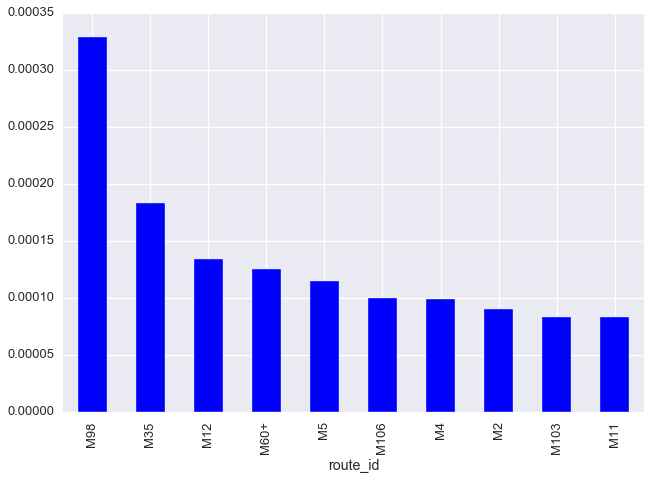

In [321]:
# Compute Speed Data
speed_data = pd.DataFrame(result_data)
speed_data.columns = ['route_id', 'dist_mi', 'time_hr', 'avg_speed']
speed_data.set_index('route_id', inplace=True)
speed_data.sort_values('avg_speed', ascending=False, inplace=True)
print(speed_data.head(3))
speed_data.head(10).avg_speed.plot(kind='bar')


# 2d

In [332]:
speed_data['minute_sqrd'] = avg_speed * 3600

print("VARIANCE : {:.9f}".format(speed_data.minute_sqrd.var()))
# speed_data.head()

VARIANCE : 0.000000000


# Temp

In [ ]:
# Find interval
rt_mhtn_bus_route_times['Interval'] = rt_mhtn_bus_route_times.apply(findinterval, axis=1)
rt_mhtn_bus_route_times.tail()

In [1124]:
# grouped = rt_mhtn_bus_route_times.groupby('route_id')
# Setup a for loop later but use single for now
bus_route = grouped[sel_cols].get_group('M35')


def change_bad_date(xtime):
    try:
        new_time = pd.to_datetime(xtime)
    except ValueError:
        hr, ms, sec = xtime.split(':')
        new_hr = divmod(int(hr), 24)
        new_time = (':').join([str(new_hr)[1], ms, sec])
        new_time = pd.to_datetime(new_time)
    return new_time


# Test
change_bad_date(xtime = "23:42:12")



# Find time interval
def findinterval(dfm):
    if dfm['new_timestamp'] < dfm['mod_depart_time']:
        dfm['new_timestamp'] += pd.Timedelta(days=1)
    return dfm['new_timestamp'] - dfm['mod_depart_time']



# TEST
df = bus_route.copy()
df['mod_depart_time'] = df.departure_time.apply(change_bad_date)
date = pd.to_datetime(df.timestamp)
df['new_timestamp'] = date.apply(lambda x: x.replace(year=2016))

df['Interval'] = df.apply(findinterval, axis=1)
df.tail()

,route_id,dist_along_route,departure_time,timestamp,mod_depart_time,new_timestamp,Interval
14687812,M35,4956.98,25:05:00,2016-01-31 01:04:08,2016-01-31 01:05:00,2016-01-31 01:04:08,23:59:08
14687813,M35,4956.98,25:05:00,2016-01-31 01:04:39,2016-01-31 01:05:00,2016-01-31 01:04:39,23:59:39
14687814,M35,4956.98,25:05:00,2016-01-31 01:05:10,2016-01-31 01:05:00,2016-01-31 01:05:10,00:00:10
14687815,M35,5165.61,25:05:00,2016-01-31 01:05:41,2016-01-31 01:05:00,2016-01-31 01:05:41,00:00:41
14687816,M35,5320.77,25:05:00,2016-01-31 01:06:13,2016-01-31 01:05:00,2016-01-31 01:06:13,00:01:13


## GroupBy

In [1]:
# df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
#                           'foo', 'bar', 'foo', 'foo'],
#                    'B' : ['one', 'one', 'two', 'three',
#                           'two', 'two', 'one', 'three'],
#                    'C' : np.random.randn(8),
#                    'D' : np.random.randn(8)})

df

NameError: name 'df' is not defined

In [580]:

for name, grp in df.groupby('A'):
    print('\n',grp)
    print('\n', name)


      A      B         C         D
1  bar    one -2.322561  0.020186
3  bar  three  0.490718  1.226637
5  bar    two  1.092246 -0.040512

 bar

      A      B         C         D
0  foo    one  0.404945  0.156542
2  foo    two -0.633588  0.873406
4  foo    two  0.190599 -0.430679
6  foo    one  1.551159 -2.256144
7  foo  three -0.691580  0.860422

 foo


In [588]:
print(df.A.unique())

grouped = df.groupby('A')

grouped.get_group('bar')

['foo' 'bar']


,A,B,C,D
1,bar,one,-2.322561,0.020186
3,bar,three,0.490718,1.226637
5,bar,two,1.092246,-0.040512


In [589]:
grouped.get_group('foo')

,A,B,C,D
0,foo,one,0.404945,0.156542
2,foo,two,-0.633588,0.873406
4,foo,two,0.190599,-0.430679
6,foo,one,1.551159,-2.256144
7,foo,three,-0.691580,0.860422


In [592]:
# Groupby COLUMNS
def get_letter_type(letter):
    if letter.lower() in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'
    
grouped = df.groupby(get_letter_type, axis=1)

grouped.get_group('consonant')

,B,C,D
0,one,0.404945,0.156542
1,one,-2.322561,0.020186
2,two,-0.633588,0.873406
3,three,0.490718,1.226637
4,two,0.190599,-0.430679
5,two,1.092246,-0.040512
6,one,1.551159,-2.256144
7,three,-0.691580,0.860422


,A,B,C,D
0,foo,one,0.404945,0.156542
1,bar,one,-2.322561,0.020186
2,foo,two,-0.633588,0.873406
3,bar,three,0.490718,1.226637
4,foo,two,0.190599,-0.430679
5,bar,two,1.092246,-0.040512
6,foo,one,1.551159,-2.256144
7,foo,three,-0.691580,0.860422


In [225]:
left1 = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                     'A': ['A0', 'A1', 'A2', 'A3'],
                     'B': ['B0', 'B1', 'B2', 'B3']})


left = pd.DataFrame({'A': ['A0', 'A1', 'A2'], 
                     'B': ['B0', 'B1', 'B2']},
                    index=['K0', 'K1', 'K2'])


left2 = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K2'],
                     'A': ['A0', 'A1', 'A2', 'A2'],
                     'B': ['B0', 'B1', 'B2', 'B2']})

left2

,A,B,key
0,A0,B0,K0
1,A1,B1,K1
2,A2,B2,K2
3,A2,B2,K2


In [227]:
right1 = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K2', 'K1'],
                      'C': ['C0', 'C1', 'C2', 'C2', 'C3'],
                      'D': ['D0', 'D1', 'D2', 'D2', 'D3']})

right = pd.DataFrame({'C': ['C0', 'C2', 'C3'],
                      'D': ['D0', 'D2', 'D3']},
                     index=['K0', 'K2', 'K3'])

right1

,C,D,key
0,C0,D0,K0
1,C1,D1,K1
2,C2,D2,K2
3,C2,D2,K2
4,C3,D3,K1


In [483]:
pd.merge(right1, left2, left_on='key', right_on='key', how='left')

,C,D,key,A,B
0,C0,D0,K0,A0,B0
1,C1,D1,K1,A1,B1
2,C2,D2,K2,A2,B2
3,C2,D2,K2,A2,B2
4,C2,D2,K2,A2,B2
5,C2,D2,K2,A2,B2
6,C3,D3,K1,A1,B1


In [482]:
pd.merge(right1, left2, left_on='key', right_on='key', how='inner')

,C,D,key,A,B
0,C0,D0,K0,A0,B0
1,C1,D1,K1,A1,B1
2,C3,D3,K1,A1,B1
3,C2,D2,K2,A2,B2
4,C2,D2,K2,A2,B2
5,C2,D2,K2,A2,B2
6,C2,D2,K2,A2,B2


In [231]:
# left2.join(right1, on='key', how='inner')

pd.merge(left2, right1, left_on='key', right_on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K1,C1,D1
2,A1,B1,K1,C3,D3
3,A2,B2,K2,C2,D2
4,A2,B2,K2,C2,D2
5,A2,B2,K2,C2,D2
6,A2,B2,K2,C2,D2


In [196]:
# Where the index of interest is already on right1
right1.join(left, on='key')

,C,D,key,A,B
0,C0,D0,K0,A0,B0
1,C1,D1,K1,A1,B1
2,C2,D2,K2,A2,B2
3,C3,D3,K1,A1,B1


In [204]:
pd.merge(right1,left, right_index='on', left_on='key')

,C,D,key,A,B
0,C0,D0,K0,A0,B0
1,C1,D1,K1,A1,B1
3,C3,D3,K1,A1,B1
2,C2,D2,K2,A2,B2


In [217]:
pd.merge(left, right1, left_index='on', right_on='key', how='inner')

,A,B,C,D,key
0,A0,B0,C0,D0,K0
1,A1,B1,C1,D1,K1
3,A1,B1,C3,D3,K1
2,A2,B2,C2,D2,K2


In [180]:
pd.merge(left, right1, left_index='on', right_on='key', how='left')

,A,B,C,D,key
0,A0,B0,C0,D0,K0
1,A1,B1,C1,D1,K1
2,A2,B2,C2,D2,K2


In [139]:
pd.merge(left, right, left_on='key', right_on='key', how='right')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K1,C1,D1
2,A3,B3,K1,C1,D1
3,A1,B1,K1,C3,D3
4,A3,B3,K1,C3,D3
5,A2,B2,K2,C2,D2


In [140]:
pd.merge(left, right, left_on='key', right_on='key', how='inner')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K1,C1,D1
2,A1,B1,K1,C3,D3
3,A3,B3,K1,C1,D1
4,A3,B3,K1,C3,D3
5,A2,B2,K2,C2,D2


In [132]:
pd.merge(left, right, on='key')

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K1,C1,D1
2,A1,B1,K1,C3,D3
3,A3,B3,K1,C1,D1
4,A3,B3,K1,C3,D3
5,A2,B2,K2,C2,D2


In [183]:
left.join?